In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE 
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer 
import warnings
warnings.filterwarnings('ignore')
sns.set()


Recolección de datos

In [30]:
#cargamos los csv y los concatenamos
df1 = pd.read_csv('UNSW-NB15_1.csv', header=None) 
df2 = pd.read_csv('UNSW-NB15_2.csv', header=None)
df3 = pd.read_csv('UNSW-NB15_3.csv', header=None)
df4 = pd.read_csv('UNSW-NB15_4.csv', header=None)
df=pd.concat([df1,df2,df3,df4], axis=0) 

#Nombramos las columnas
df.columns = ['srcip','sport','dstip','dsport','proto','state','dur','sbytes','dbytes','sttl','dttl','sloss','dloss','service','sload','dload','spkts','dpkts',
            'swin','dwin','stcpb','dtcpb','smeansz','dmeansz','trans_depth','res_bdy_len','sjit','djit','stime','ltime','sintpkt','dintpkt','tcprtt','synack',
            'ackdat','is_sm_ips_ports','ct_state_ttl','ct_flw_http_mthd','is_ftp_login','ct_ftp_cmd','ct_srv_src','ct_srv_dst','ct_dst_ltm','ct_src_ltm',
            'ct_src_dport_ltm','ct_dst_sport_ltm','ct_dst_src_ltm','attack_cat','label']
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540047 entries, 0 to 440043
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit           

(2540047, 49)

In [31]:
# Eliminamos los campos relacionados con la IP de origen y destino
# Eliminamos los campos que marcan el tiempo de captura de flujo
df= df.drop(['srcip','sport','dstip','dsport', 'stime', 'ltime', 'dur'],1) 

# La columna ct_ftp_cmd tiene entradas invalidas.
# Las convertimos en numericas y sobreescribimos el resto con valores nulos
df['ct_ftp_cmd']=pd.to_numeric(df['ct_ftp_cmd'], errors='coerce').fillna(0).astype('int64') 
df=df.fillna(0) 

# Reemplazamos '-' en state y service por 'other'
df['state'] = df['state'].replace('-','otro')
df['service'] = df['service'].replace('-','otro')

# Eliminamos los espacios para evitar duplicados: 
df['attack_cat']=df['attack_cat'].str.strip()
df['attack_cat'].value_counts()

# Remplezamos los valores nulos de la columna 'attack_cat' por 'normal'
df['attack_cat'].fillna('Normal',inplace=True)
df['attack_cat'].value_counts()

#comprobamos que no falten valores
df.isna().sum()

df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2540047 entries, 0 to 440043
Data columns (total 42 columns):
 #   Column            Dtype  
---  ------            -----  
 0   proto             object 
 1   state             object 
 2   sbytes            int64  
 3   dbytes            int64  
 4   sttl              int64  
 5   dttl              int64  
 6   sloss             int64  
 7   dloss             int64  
 8   service           object 
 9   sload             float64
 10  dload             float64
 11  spkts             int64  
 12  dpkts             int64  
 13  swin              int64  
 14  dwin              int64  
 15  stcpb             int64  
 16  dtcpb             int64  
 17  smeansz           int64  
 18  dmeansz           int64  
 19  trans_depth       int64  
 20  res_bdy_len       int64  
 21  sjit              float64
 22  djit              float64
 23  sintpkt           float64
 24  dintpkt           float64
 25  tcprtt            float64
 26  synack         

(2540047, 42)

Limpieza de datos y exploracion Set Completo

In [32]:
df.groupby('attack_cat').size()

#Agrupamos Backdoor y Backdoors
df['attack_cat'] = df['attack_cat'].apply(lambda item: 'Backdoor' if item =='Backdoors' else item)
attack_by_cat = df.groupby('attack_cat').size().reset_index(name='counts')
attack_by_cat = attack_by_cat.sort_values(by = "counts", ascending=False) 
attack_by_cat = attack_by_cat.reset_index()
attack_by_cat

,index,attack_cat,counts
0,6,Normal,2218764
1,5,Generic,215481
2,3,Exploits,44525
3,4,Fuzzers,24246
4,2,DoS,16353
5,7,Reconnaissance,13987
6,0,Analysis,2677
7,1,Backdoor,2329
8,8,Shellcode,1511
9,9,Worms,174


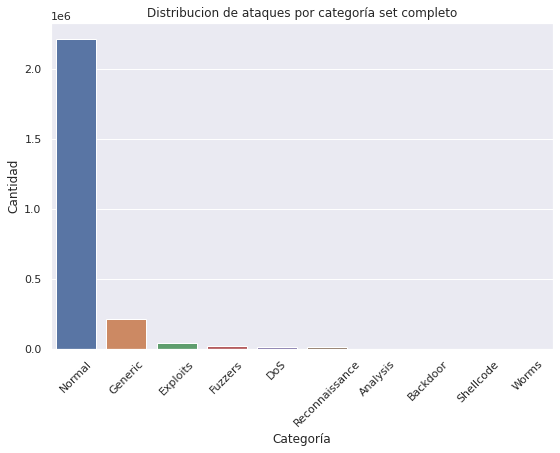

In [33]:
#Distribucion de ataques por categoria
plt.figure(figsize=(9,6))
ax = sns.barplot(x='attack_cat',y='counts',data=attack_by_cat)
ax.set_title('Distribucion de ataques por categoría set completo')
ax.set_xlabel('Categoría')
ax.set_ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

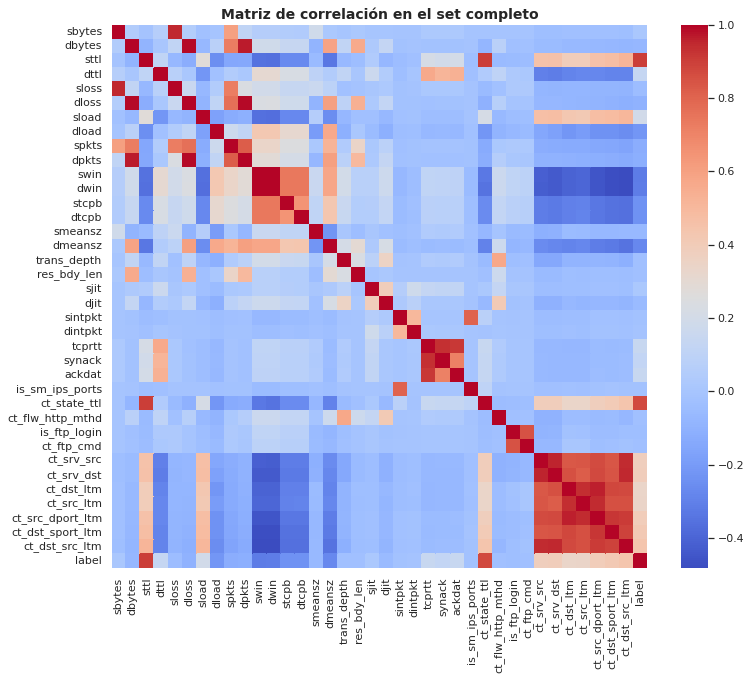

In [34]:
#Correlacion de caracteristicas
plt.figure(figsize=(12,10)) 
plt.title('Matriz de correlación en el set completo', fontsize=14, fontweight='bold') 
correl = df.corr() 
sns.heatmap(correl, cmap='coolwarm') 
plt.show()




[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.041s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.361819
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.197895
[t-SNE] KL divergence after 300 iterations: 0.343046


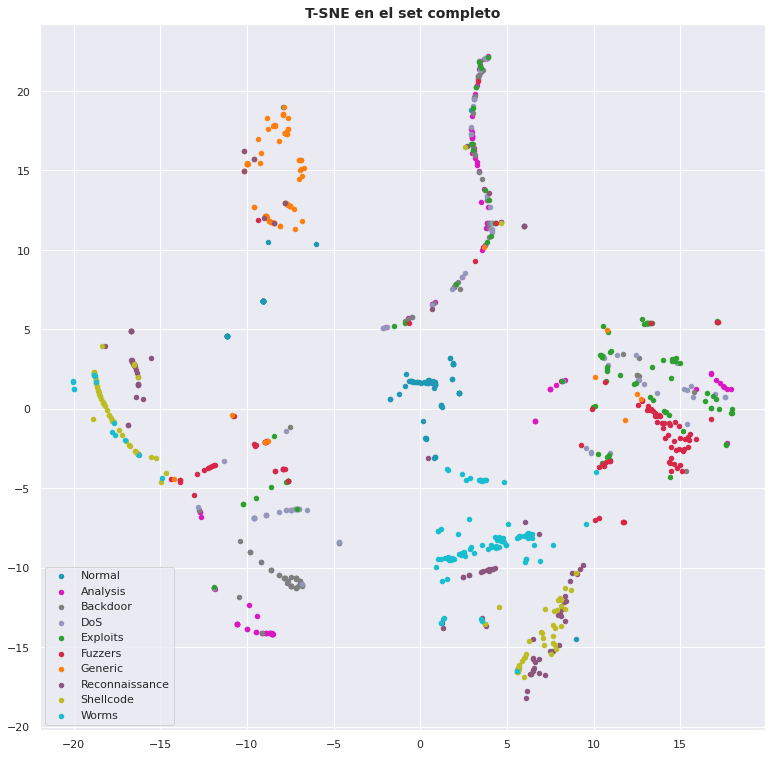

In [38]:
#T-SNE Scatter plot

for col_name in df.columns: 
  if df[col_name].dtypes == 'object' :
    le = preprocessing.LabelEncoder() 
    unique_cat = len(df[col_name].unique()) 
    print("El feature '{col_name}' tiene {unique_cat} categorías".format(col_name=col_name, unique_cat=unique_cat)) 
    df[col_name] = le.fit_transform(df[col_name]) 
    mapeo = dict(zip(le.classes_, le.transform(le.classes_))) 
    print(mapeo) 
    print() 
# Eliminamos las variables categoricas para quedarnos con las numericas 
categoria=['proto','service','state','attack_cat'] 
num=df.columns 
num=num.drop(categoria) 
numc=pd.Index(num) 
num=num.to_list() 

#Guardamos el nombre y el tipo de dato
columnas=num + categoria 
types=df.dtypes 

#reeordenamos los tipos para asociarlos a las categorias
types= types.reindex(columnas)

#normalizamos las variables numericas
sca=StandardScaler() 
 
 # passthrough para dejar el resto de columnas igual
column_trans = ColumnTransformer([('scaler', sca, num)],remainder='passthrough') 

df= column_trans.fit_transform(df) 
 
# reconvertimos a Df 
df=pd.DataFrame(df,columns=columnas) 
retype = dict(zip(columnas, types.tolist())) 
df = df.astype(retype)  
print()
 
 
nor = df.query('attack_cat == 6').sample(100) 
an = df.query('attack_cat == 0').sample(100) 
back = df.query('attack_cat == 1').sample(100) 
dos = df.query('attack_cat == 2').sample(100) 
expl = df.query('attack_cat == 3').sample(100) 
fuzz = df.query('attack_cat == 4').sample(100) 
gen = df.query('attack_cat == 5').sample(100) 
reco = df.query('attack_cat == 7').sample(100) 
shell = df.query('attack_cat == 8').sample(100) 
worm = df.query('attack_cat == 9').sample(100) 
 
# Concatenamos las 100 muestras aleatorias de cada clase que hemos escogido en 
# un vector llamado setred 
setred=pd.concat([nor,an,back,dos,expl,fuzz,gen,reco,shell,worm],axis=0) 
 
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(setred) 

 
# hay 40 muestras de cada clase. La última muestra de la primera clase está en
# la posición 39, la ultima de la 2da clase en el fin_index+40, etc. 
fin_index=num_samples-1 

fig = plt.figure(figsize=(13,13)) 
ax1 = fig.add_subplot(111) 

colores = ['#1f98b4', '#ff7f0e', '#2ca02c', '#d62748', '#9497bc', '#8c557b', '#da17c2', '#7f7f7f', '#bcbd22', '#17becf'] 

ax1.scatter(tsne[0:fin_index, 0], tsne[0:fin_index, 1], 20, colores[0],label='Normal') 
ax1.scatter(tsne[fin_index+1:fin_index*2, 0], tsne[fin_index+1:fin_index*2, 1],20, colores[6],label='Analysis') 
ax1.scatter(tsne[(fin_index*2)+1:fin_index*3, 0], tsne[(fin_index*2)+1:fin_index*3, 1], 20, colores[7],label='Backdoor') 
ax1.scatter(tsne[(fin_index*3)+1:fin_index*4, 0], tsne[(fin_index*3)+1:fin_index*4, 1], 20, colores[4],label='DoS') 
ax1.scatter(tsne[(fin_index*4)+1:fin_index*5, 0], tsne[(fin_index*4)+1:fin_index*5, 1], 20, colores[2],label='Exploits') 
ax1.scatter(tsne[(fin_index*5)+1:fin_index*6, 0], tsne[(fin_index*5)+1:fin_index*6, 1], 20, colores[3],label='Fuzzers') 
ax1.scatter(tsne[(fin_index*6)+1:fin_index*7, 0], tsne[(fin_index*6)+1:fin_index*7, 1], 20, colores[1],label='Generic') 
ax1.scatter(tsne[(fin_index*7)+1:fin_index*8, 0], tsne[(fin_index*7)+1:fin_index*8, 1], 20, colores[5],label='Reconnaissance') 
ax1.scatter(tsne[(fin_index*8)+1:fin_index*9, 0], tsne[(fin_index*8)+1:fin_index*9, 1], 20, colores[8],label='Shellcode') 
ax1.scatter(tsne[(fin_index*9)+1:fin_index*10, 0], tsne[(fin_index*9)+1:fin_index*10, 1], 20, colores[9],label='Worms') 

plt.title('T-SNE en el set completo' , fontsize=14, fontweight='bold') 
plt.legend(loc='lower left') 
plt.show()


Set Reducido

In [23]:
#Dataset reducido
df_train = pd.read_csv('UNSW_NB15_training-set.csv',header=0) 
df_test = pd.read_csv('UNSW_NB15_testing-set.csv',header=0) 
df_red = pd.concat([df_train,df_test], axis=0)
df_red.columns = ['id','dur','proto','service','state','spkts','dpkts',
                       'sbytes','dbytes','rate','sttl','dttl','sload','dload',
                       'sloss','dloss','sintpkt','dintpkt','sjit', 'djit',
                       'swin','stcpb','dtcpb','dwin','tcprtt','synack','ackdat',
                       'smean','dmean','trans_depth','res_bdy_len', 'ct_srv_dst',
                       'ct_state_ttl','ct_dst_ltm','ct_src_dport_ltm','ct_dst_sport_ltm',
                       'ct_dst_src_ltm','is_ftp_login','ct_ftp_cmd','ct_flw_http_mthd',
                       'ct_src_ltm','ct_srv_src','is_sm_ips_ports','attack_cat','label'] 

#Limpieza de datos
# Eliminamos id
df_red= df_red.drop(['id'],1) 

# La columna ct_ftp_cmd tiene entradas invalidas.
# Las convertimos en numericas y sobreescribimos el resto con valores nulos
df_red['ct_ftp_cmd']=pd.to_numeric(df_red['ct_ftp_cmd'], errors='coerce').fillna(0).astype('int64') 
df_red=df_red.fillna(0) 

# Eliminamos los espacios para evitar duplicados: 
df_red['attack_cat']=df_red['attack_cat'].str.strip()
df_red['attack_cat'].value_counts()

# Remplezamos los valores nulos de la columna 'attack_cat' por 'normal'
df_red['attack_cat'].fillna('Normal',inplace=True)
df_red['attack_cat'].value_counts()

#comprobamos que no falten valores
df_red.isna().sum()

df_red.info()
df_red.shape

df_red.groupby('attack_cat').size()

#Agrupamos Backdoor y Backdoors
df_red['attack_cat'] = df_red['attack_cat'].apply(lambda item: 'Backdoor' if item =='Backdoors' else item)
attack_by_cat = df_red.groupby('attack_cat').size().reset_index(name='counts')
attack_by_cat = attack_by_cat.sort_values(by = "counts", ascending=False) 
attack_by_cat = attack_by_cat.reset_index()
attack_by_cat

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 175340
Data columns (total 44 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   dur               257673 non-null  float64
 1   proto             257673 non-null  object 
 2   service           257673 non-null  object 
 3   state             257673 non-null  object 
 4   spkts             257673 non-null  int64  
 5   dpkts             257673 non-null  int64  
 6   sbytes            257673 non-null  int64  
 7   dbytes            257673 non-null  int64  
 8   rate              257673 non-null  float64
 9   sttl              257673 non-null  int64  
 10  dttl              257673 non-null  int64  
 11  sload             257673 non-null  float64
 12  dload             257673 non-null  float64
 13  sloss             257673 non-null  int64  
 14  dloss             257673 non-null  int64  
 15  sintpkt           257673 non-null  float64
 16  dintpkt           25

,index,attack_cat,counts
0,6,Normal,93000
1,5,Generic,58871
2,3,Exploits,44525
3,4,Fuzzers,24246
4,2,DoS,16353
5,7,Reconnaissance,13987
6,0,Analysis,2677
7,1,Backdoor,2329
8,8,Shellcode,1511
9,9,Worms,174


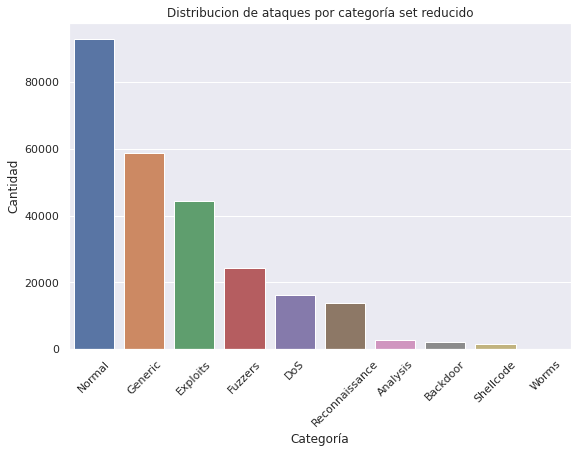

In [24]:
#Distribucion de ataques por categoria
plt.figure(figsize=(9,6))
ax = sns.barplot(x='attack_cat',y='counts',data=attack_by_cat)
ax.set_title('Distribucion de ataques por categoría set reducido')
ax.set_xlabel('Categoría')
ax.set_ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

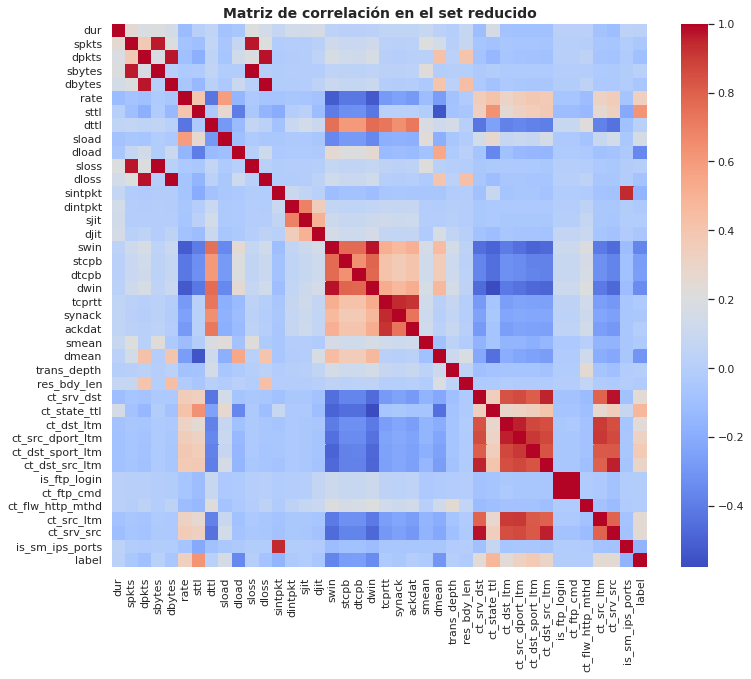

In [25]:
#Correlacion de caracteristicas set reducido
plt.figure(figsize=(12,10)) 
plt.title('Matriz de correlación en el set reducido', fontsize=14, fontweight='bold') 
correl = df_red.corr() 
sns.heatmap(correl, cmap='coolwarm') 
plt.show()

In [26]:
df=df_red


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.263418
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.871017
[t-SNE] KL divergence after 300 iterations: 0.336035


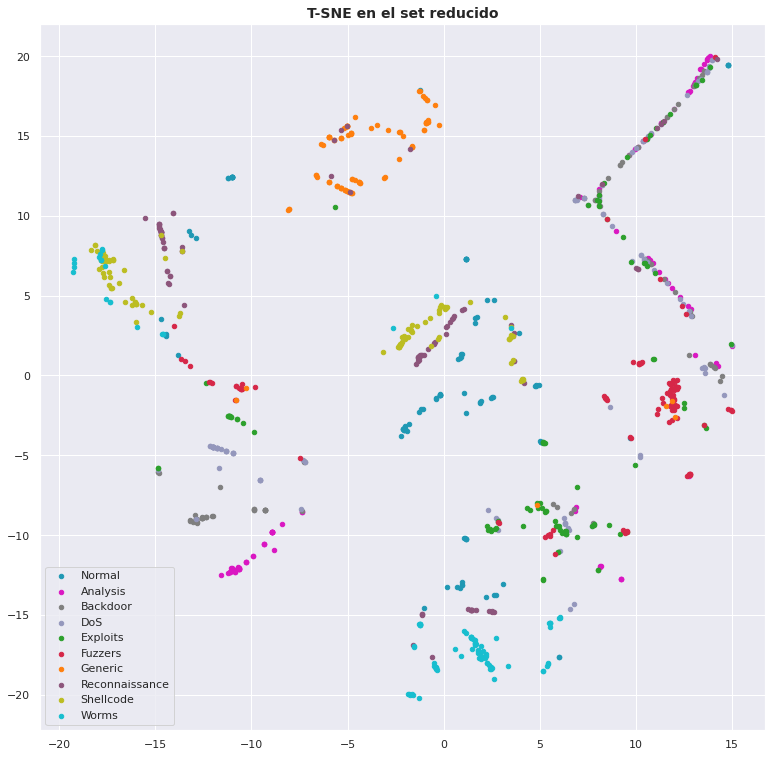

In [29]:
#T-SNE Scatter plot

for col_name in df.columns: 
  if df[col_name].dtypes == 'object' :
    le = preprocessing.LabelEncoder() 
    unique_cat = len(df[col_name].unique()) 
    print("El feature '{col_name}' tiene {unique_cat} categorías".format(col_name=col_name, unique_cat=unique_cat)) 
    df[col_name] = le.fit_transform(df[col_name]) 
    mapeo = dict(zip(le.classes_, le.transform(le.classes_))) 
    print(mapeo) 
    print() 
# Eliminamos las variables categoricas para quedarnos con las numericas 
categoria=['proto','service','state','attack_cat'] 
num=df.columns 
num=num.drop(categoria) 
numc=pd.Index(num) 
num=num.to_list() 

#Guardamos el nombre y el tipo de dato
columnas=num + categoria 
types=df.dtypes 

#reeordenamos los tipos para asociarlos a las categorias
types= types.reindex(columnas)

#normalizamos las variables numericas
sca=StandardScaler() 
 
 # passthrough para dejar el resto de columnas igual
column_trans = ColumnTransformer([('scaler', sca, num)],remainder='passthrough') 

df= column_trans.fit_transform(df) 
 
# reconvertimos a Df 
df=pd.DataFrame(df,columns=columnas) 
retype = dict(zip(columnas, types.tolist())) 
df = df.astype(retype)  
print()
 
 
nor = df.query('attack_cat == 6').sample(100) 
an = df.query('attack_cat == 0').sample(100) 
back = df.query('attack_cat == 1').sample(100) 
dos = df.query('attack_cat == 2').sample(100) 
expl = df.query('attack_cat == 3').sample(100) 
fuzz = df.query('attack_cat == 4').sample(100) 
gen = df.query('attack_cat == 5').sample(100) 
reco = df.query('attack_cat == 7').sample(100) 
shell = df.query('attack_cat == 8').sample(100) 
worm = df.query('attack_cat == 9').sample(100) 
 
# Concatenamos las 100 muestras aleatorias de cada clase que hemos escogido en 
# un vector llamado setred 
setred=pd.concat([nor,an,back,dos,expl,fuzz,gen,reco,shell,worm],axis=0) 
 
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(setred) 

 
# hay 40 muestras de cada clase. La última muestra de la primera clase está en
# la posición 39, la ultima de la 2da clase en el fin_index+40, etc. 
fin_index=num_samples-1 

fig = plt.figure(figsize=(13,13)) 
ax1 = fig.add_subplot(111) 

colores = ['#1f98b4', '#ff7f0e', '#2ca02c', '#d62748', '#9497bc', '#8c557b', '#da17c2', '#7f7f7f', '#bcbd22', '#17becf'] 

ax1.scatter(tsne[0:fin_index, 0], tsne[0:fin_index, 1], 20, colores[0],label='Normal') 
ax1.scatter(tsne[fin_index+1:fin_index*2, 0], tsne[fin_index+1:fin_index*2, 1],20, colores[6],label='Analysis') 
ax1.scatter(tsne[(fin_index*2)+1:fin_index*3, 0], tsne[(fin_index*2)+1:fin_index*3, 1], 20, colores[7],label='Backdoor') 
ax1.scatter(tsne[(fin_index*3)+1:fin_index*4, 0], tsne[(fin_index*3)+1:fin_index*4, 1], 20, colores[4],label='DoS') 
ax1.scatter(tsne[(fin_index*4)+1:fin_index*5, 0], tsne[(fin_index*4)+1:fin_index*5, 1], 20, colores[2],label='Exploits') 
ax1.scatter(tsne[(fin_index*5)+1:fin_index*6, 0], tsne[(fin_index*5)+1:fin_index*6, 1], 20, colores[3],label='Fuzzers') 
ax1.scatter(tsne[(fin_index*6)+1:fin_index*7, 0], tsne[(fin_index*6)+1:fin_index*7, 1], 20, colores[1],label='Generic') 
ax1.scatter(tsne[(fin_index*7)+1:fin_index*8, 0], tsne[(fin_index*7)+1:fin_index*8, 1], 20, colores[5],label='Reconnaissance') 
ax1.scatter(tsne[(fin_index*8)+1:fin_index*9, 0], tsne[(fin_index*8)+1:fin_index*9, 1], 20, colores[8],label='Shellcode') 
ax1.scatter(tsne[(fin_index*9)+1:fin_index*10, 0], tsne[(fin_index*9)+1:fin_index*10, 1], 20, colores[9],label='Worms') 

plt.title('T-SNE en el set reducido' , fontsize=14, fontweight='bold') 
plt.legend(loc='lower left') 
plt.show()

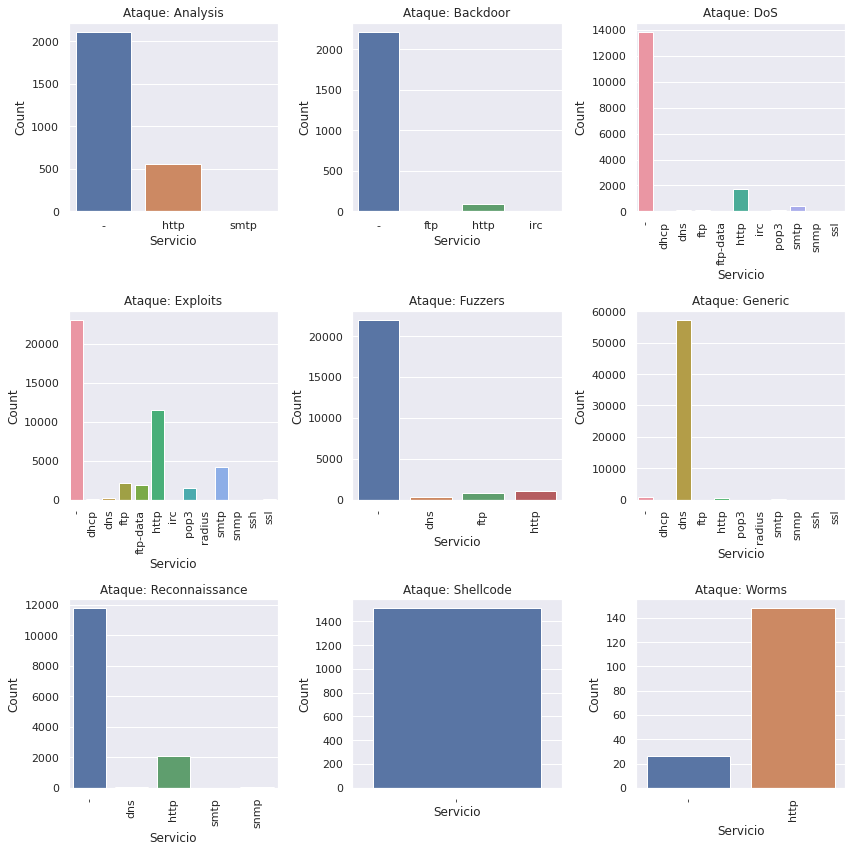

In [ ]:
#Servicios mas usados por ataque
df_services = df[(df['attack_cat']!='Normal')].groupby(['attack_cat','service']).size().reset_index(name='Count')
fig, ax = plt.subplots(3,3, figsize=(12,12))
ax[0,0] = sns.barplot(data=df_services[df_services['attack_cat']=='Analysis'], x='service',y='Count', ax=ax[0,0])
ax[0,0].set_title('Ataque: Analysis')
ax[0,0].set_xlabel('Servicio')
ax[0,1] = sns.barplot(data=df_services[df_services['attack_cat']=='Backdoor'], x='service',y='Count', ax=ax[0,1])
ax[0,1].set_title('Ataque: Backdoor')
ax[0,1].set_xlabel('Servicio')
ax[0,2] = sns.barplot(data=df_services[df_services['attack_cat']=='DoS'], x='service',y='Count', ax=ax[0,2])
ax[0,2].set_title('Ataque: DoS')
ax[0,2].set_xlabel('Servicio')
ax[0,2].tick_params(axis='x', labelrotation = 90)
ax[1,0] = sns.barplot(data=df_services[df_services['attack_cat']=='Exploits'], x='service',y='Count', ax=ax[1,0])
ax[1,0].set_title('Ataque: Exploits')
ax[1,0].set_xlabel('Servicio')
ax[1,0].tick_params(axis='x', labelrotation = 90)
ax[1,1] = sns.barplot(data=df_services[df_services['attack_cat']=='Fuzzers'], x='service',y='Count', ax=ax[1,1])
ax[1,1].set_title('Ataque: Fuzzers')
ax[1,1].set_xlabel('Servicio')
ax[1,1].tick_params(axis='x', labelrotation = 90)
ax[1,2] = sns.barplot(data=df_services[df_services['attack_cat']=='Generic'], x='service',y='Count', ax=ax[1,2])
ax[1,2].set_title('Ataque: Generic')
ax[1,2].set_xlabel('Servicio')
ax[1,2].tick_params(axis='x', labelrotation = 90)
ax[2,0] = sns.barplot(data=df_services[df_services['attack_cat']=='Reconnaissance'], x='service',y='Count', ax=ax[2,0])
ax[2,0].set_title('Ataque: Reconnaissance')
ax[2,0].set_xlabel('Servicio')
ax[2,0].tick_params(axis='x', labelrotation = 90)
ax[2,1] = sns.barplot(data=df_services[df_services['attack_cat']=='Shellcode'], x='service',y='Count', ax=ax[2,1])
ax[2,1].set_title('Ataque: Shellcode')
ax[2,1].set_xlabel('Servicio')
ax[2,1].tick_params(axis='x', labelrotation = 90)
ax[2,2] = sns.barplot(data=df_services[df_services['attack_cat']=='Worms'], x='service',y='Count', ax=ax[2,2])
ax[2,2].set_title('Ataque: Worms')
ax[2,2].set_xlabel('Servicio')
ax[2,2].tick_params(axis='x', labelrotation = 90)
plt.tight_layout()

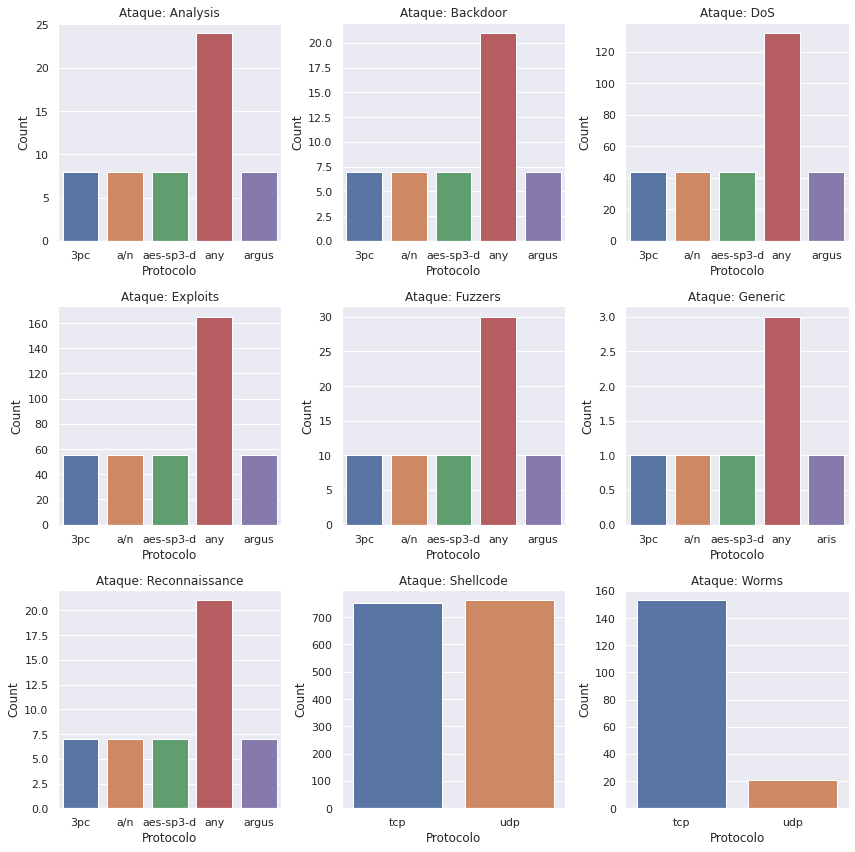

In [ ]:
#Protocolos mas usados por ataque 
df_proto= df[(df['attack_cat']!='Normal')].groupby(['attack_cat','proto']).size().reset_index(name='Count')
fig, ax = plt.subplots(3,3, figsize=(12,12))
ax[0,0] = sns.barplot(data=df_proto[df_proto['attack_cat']=='Analysis'][:5], x='proto',y='Count', ax=ax[0,0])
ax[0,0].set_title('Ataque: Analysis')
ax[0,0].set_xlabel('Protocolo')
ax[0,1] = sns.barplot(data=df_proto[df_proto['attack_cat']=='Backdoor'][:5], x='proto',y='Count', ax=ax[0,1])
ax[0,1].set_title('Ataque: Backdoor')
ax[0,1].set_xlabel('Protocolo')
ax[0,2] = sns.barplot(data=df_proto[df_proto['attack_cat']=='DoS'][:5], x='proto',y='Count', ax=ax[0,2])
ax[0,2].set_title('Ataque: DoS')
ax[0,2].set_xlabel('Protocolo')
ax[1,0] = sns.barplot(data=df_proto[df_proto['attack_cat']=='Exploits'][:5], x='proto',y='Count', ax=ax[1,0])
ax[1,0].set_title('Ataque: Exploits')
ax[1,0].set_xlabel('Protocolo')
ax[1,1] = sns.barplot(data=df_proto[df_proto['attack_cat']=='Fuzzers'][:5], x='proto',y='Count', ax=ax[1,1])
ax[1,1].set_title('Ataque: Fuzzers')
ax[1,1].set_xlabel('Protocolo')
ax[1,2] = sns.barplot(data=df_proto[df_proto['attack_cat']=='Generic'][:5], x='proto',y='Count', ax=ax[1,2])
ax[1,2].set_title('Ataque: Generic')
ax[1,2].set_xlabel('Protocolo')
ax[2,0] = sns.barplot(data=df_proto[df_proto['attack_cat']=='Reconnaissance'][:5], x='proto',y='Count', ax=ax[2,0])
ax[2,0].set_title('Ataque: Reconnaissance')
ax[2,0].set_xlabel('Protocolo')
ax[2,1] = sns.barplot(data=df_proto[df_proto['attack_cat']=='Shellcode'][:5], x='proto',y='Count', ax=ax[2,1])
ax[2,1].set_title('Ataque: Shellcode')
ax[2,1].set_xlabel('Protocolo')
ax[2,2] = sns.barplot(data=df_proto[df_proto['attack_cat']=='Worms'][:5], x='proto',y='Count', ax=ax[2,2])
ax[2,2].set_title('Ataque: Worms')
ax[2,2].set_xlabel('Protocolo')
plt.tight_layout()

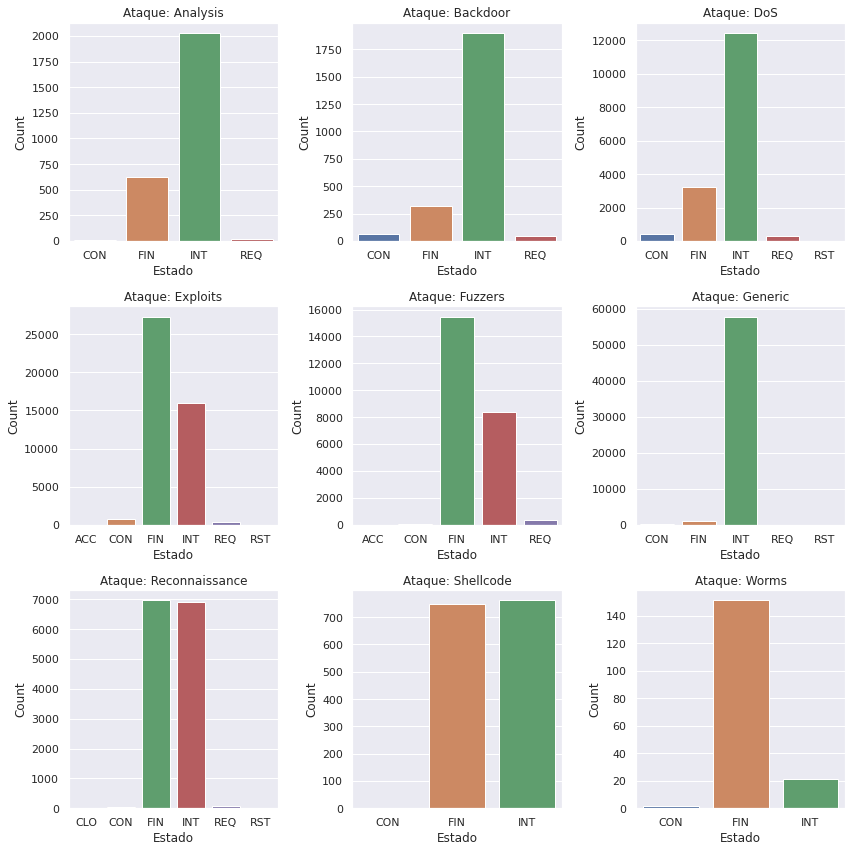

In [ ]:
# Estados por ataque
df_attacks_cat_state = df[(df['attack_cat']!='Normal')].groupby(['attack_cat','state']).size().reset_index(name='Count')
fig, ax = plt.subplots(3,3, figsize=(12,12))
ax[0,0] = sns.barplot(data=df_attacks_cat_state[df_attacks_cat_state['attack_cat']=='Analysis'], x='state',y='Count', ax=ax[0,0])
ax[0,0].set_title('Ataque: Analysis')
ax[0,0].set_xlabel('Estado')
ax[0,1] = sns.barplot(data=df_attacks_cat_state[df_attacks_cat_state['attack_cat']=='Backdoor'], x='state',y='Count', ax=ax[0,1])
ax[0,1].set_title('Ataque: Backdoor')
ax[0,1].set_xlabel('Estado')
ax[0,2] = sns.barplot(data=df_attacks_cat_state[df_attacks_cat_state['attack_cat']=='DoS'], x='state',y='Count', ax=ax[0,2])
ax[0,2].set_title('Ataque: DoS')
ax[0,2].set_xlabel('Estado')
ax[1,0] = sns.barplot(data=df_attacks_cat_state[df_attacks_cat_state['attack_cat']=='Exploits'], x='state',y='Count', ax=ax[1,0])
ax[1,0].set_title('Ataque: Exploits')
ax[1,0].set_xlabel('Estado')
ax[1,1] = sns.barplot(data=df_attacks_cat_state[df_attacks_cat_state['attack_cat']=='Fuzzers'], x='state',y='Count', ax=ax[1,1])
ax[1,1].set_title('Ataque: Fuzzers')
ax[1,1].set_xlabel('Estado')
ax[1,2] = sns.barplot(data=df_attacks_cat_state[df_attacks_cat_state['attack_cat']=='Generic'], x='state',y='Count', ax=ax[1,2])
ax[1,2].set_title('Ataque: Generic')
ax[1,2].set_xlabel('Estado')
ax[2,0] = sns.barplot(data=df_attacks_cat_state[df_attacks_cat_state['attack_cat']=='Reconnaissance'], x='state',y='Count', ax=ax[2,0])
ax[2,0].set_title('Ataque: Reconnaissance')
ax[2,0].set_xlabel('Estado')
ax[2,1] = sns.barplot(data=df_attacks_cat_state[df_attacks_cat_state['attack_cat']=='Shellcode'], x='state',y='Count', ax=ax[2,1])
ax[2,1].set_title('Ataque: Shellcode')
ax[2,1].set_xlabel('Estado')
ax[2,2] = sns.barplot(data=df_attacks_cat_state[df_attacks_cat_state['attack_cat']=='Worms'], x='state',y='Count', ax=ax[2,2])
ax[2,2].set_title('Ataque: Worms')
ax[2,2].set_xlabel('Estado')
plt.tight_layout()